📝 *Import required libraries and files:*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#    ---- Data Scaling ----
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
#    ---- Feature Engeneering ----
from typing import Dict, Iterable
import re
#    ---- Scrape Market Value ----
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import time
import inspect
from functools import lru_cache

In [2]:
path_cleaned = r"C:\Users\pedro\OneDrive\Escritorio\Projetos\Football Scout\df_cleaned.xlsx"
path_normalized = r"C:\Users\pedro\OneDrive\Escritorio\Projetos\Football Scout\df_normalized.xlsx"

df_cleaned = pd.read_excel(path_cleaned)
print(f"Shape of df_cleaned: {df_cleaned.shape}")

df_normalized = pd.read_excel(path_normalized)
print(f"Shape of df_normalized: {df_normalized.shape}")

Shape of df_cleaned: (8996, 71)
Shape of df_normalized: (8151, 71)


In [3]:
pd.set_option('display.max_columns', None)

# 3.1. - Data Transformation

In this section we will **scale player stats** so that features that have higher units do not get disproportional importance in the scouting functions we will create next. Additionally, **new composite features** that aggregate certain topics (e.g., "defensive skills") will be created to simplify the algorithms that will be created and improve functions' generalization and usage.

## 3.1.1. - Data Scaling

To **scale player stats** the following process was followed:

- Application of winsorization (default 1.0) before MinMax so outliers don’t dominat;

- Run 'yeo-johnson' power transformation to obtain a more normal distribution and reduce impact of outliers;

- Execute 'MinMaxScaler' to put all the values in the same [0,1] range.

New columns were created in the new `df_scaled` named `*_scaled`.

In [4]:
def add_scaled_columns_full(df: pd.DataFrame, cols_to_scale, winsor_pct: float | None = 0.5):
    """
    Fits Yeo-Johnson -> MinMax on the df and writes <col>_scaled.
    Keeps originals. 
    """
    out = df.copy()

    for col in cols_to_scale:
        if col not in out.columns:
            print(f"Skip (missing): {col}")
            continue

        s = pd.to_numeric(out[col], errors="coerce")
        mask = s.notna()
        x = s[mask].to_numpy().reshape(-1, 1)

        # winsorization
        if winsor_pct is not None and len(x):
            lo, hi = np.nanpercentile(x, [winsor_pct, 100 - winsor_pct])
            x = np.clip(x, lo, hi)

        pipe = Pipeline([
            ("power", PowerTransformer(method="yeo-johnson", standardize=True)),
            ("minmax", MinMaxScaler((0, 1))),
        ])

        x_scaled = pipe.fit_transform(x).ravel() if len(x) else np.array([])
        y = np.full(len(out), np.nan, dtype=float)
        y[mask.values] = np.round(x_scaled, 3)

        out[f"{col}_scaled"] = y

    return out

In [5]:
cols_to_scale = ['Goals', 'Expected Goals','Goals Minus Expected', 'Goals not Penalty', 'Penalty Goals','Penalty Efficacy', 'Shoots', 
                 'Shoots on Target', 'Goals/Shoot','AvgShoot Distance', 'FreeKick Shoots', 'Assists', 'Crosses','Penalty Won', 'Offsides', 
                 'Cmp Passes', 'Cmp Passes%', 'Prog Passes','Passing Distance', 'Pass Prog Distance', 'Short Cmp', 'Short Cmp%','Medium Cmp', 
                 'Medium Cmp%', 'Long Cmp', 'Long Cmp%', 'Key Passes','Passes Att 3rd', 'Passes Penalty Area', 'Shoot Creating Actions',
                 'Goal Creating Actions', 'Take-Ons Att', 'Take-Ons Succ','Take-Ons Succ%', 'Fouls Suffered', 'Carries', 'Carries TotDist',
                 'Prog Carries', 'Carries PrgDist', 'Carries 1/3', 'Touches','Touches Def 3rd', 'Touches Mid 3rd', 'Touches Att 3rd','Errors',
                 'Aerial Duels', 'Aerial Duels Won%', 'Tackles', 'Tackles Won','Tackles Def 3rd', 'Tackles Mid 3rd', 'Tackles Att 3rd', 'Blocks',
                 'Interceptions', 'Ball Recoveries', 'Clearances', 'Own Goals','Fouls Commited', 'Penalty Commited', 'Yellow Cards', 'Red Cards'
]

df_scaled = add_scaled_columns_full(df_normalized, cols_to_scale, winsor_pct=1.0)

In [6]:
df_scaled.head(2)

,PlayerID,Player,League,Squad,Pos,Age,Nation,Matches,Starts,Minutes,Goals,Expected Goals,Goals Minus Expected,Goals not Penalty,Penalty Goals,Penalty Efficacy,Shoots,Shoots on Target,Goals/Shoot,AvgShoot Distance,FreeKick Shoots,Assists,Crosses,Penalty Won,Offsides,Cmp Passes,Cmp Passes%,Prog Passes,Passing Distance,Pass Prog Distance,Short Cmp,Short Cmp%,Medium Cmp,Medium Cmp%,Long Cmp,Long Cmp%,Key Passes,Passes Att 3rd,Passes Penalty Area,Shoot Creating Actions,Goal Creating Actions,Take-Ons Att,Take-Ons Succ,Take-Ons Succ%,Fouls Suffered,Carries,Carries TotDist,Prog Carries,Carries PrgDist,Carries 1/3,Touches,Touches Def 3rd,Touches Mid 3rd,Touches Att 3rd,Errors,Aerial Duels,Aerial Duels Won%,Tackles,Tackles Won,Tackles Def 3rd,Tackles Mid 3rd,Tackles Att 3rd,Blocks,Interceptions,Ball Recoveries,Clearances,Own Goals,Fouls Commited,Penalty Commited,Yellow Cards,Red Cards,Goals_scaled,Expected Goals_scaled,Goals Minus Expected_scaled,Goals not Penalty_scaled,Penalty Goals_scaled,Penalty Efficacy_scaled,Shoots_scaled,Shoots on Target_scaled,Goals/Shoot_scaled,AvgShoot Distance_scaled,FreeKick Shoots_scaled,Assists_scaled,Crosses_scaled,Penalty Won_scaled,Offsides_scaled,Cmp Passes_scaled,Cmp Passes%_scaled,Prog Passes_scaled,Passing Distance_scaled,Pass Prog Distance_scaled,Short Cmp_scaled,Short Cmp%_scaled,Medium Cmp_scaled,Medium Cmp%_scaled,Long Cmp_scaled,Long Cmp%_scaled,Key Passes_scaled,Passes Att 3rd_scaled,Passes Penalty Area_scaled,Shoot Creating Actions_scaled,Goal Creating Actions_scaled,Take-Ons Att_scaled,Take-Ons Succ_scaled,Take-Ons Succ%_scaled,Fouls Suffered_scaled,Carries_scaled,Carries TotDist_scaled,Prog Carries_scaled,Carries PrgDist_scaled,Carries 1/3_scaled,Touches_scaled,Touches Def 3rd_scaled,Touches Mid 3rd_scaled,Touches Att 3rd_scaled,Errors_scaled,Aerial Duels_scaled,Aerial Duels Won%_scaled,Tackles_scaled,Tackles Won_scaled,Tackles Def 3rd_scaled,Tackles Mid 3rd_scaled,Tackles Att 3rd_scaled,Blocks_scaled,Interceptions_scaled,Ball Recoveries_scaled,Clearances_scaled,Own Goals_scaled,Fouls Commited_scaled,Penalty Commited_scaled,Yellow Cards_scaled,Red Cards_scaled
0,1,Matías Abaldo,arg1,Independiente,FW,21.0,URU,3,3,201,0.000,0.090,-0.090,0.000,0.0,NaN,0.896,0.448,0.00,16.7,0,0.000,0.896,0.0,1.343,45,70.3,3.582,267.313,103.433,12.985,80.6,5.821,72.2,0.896,50.0,0.448,3.134,0.448,1.791,0.000,3.582,0.448,12.5,1.343,21.94,101.194,1.343,36.716,0.000,42.985,4.030,56,13.881,0.000,2.687,50.0,0.896,0.448,0.000,0.896,0.000,1.343,0.448,3.134,0.448,0.0,0.000,0.0,0.000,0.0,0.000,0.430,0.412,0.000,0.0,NaN,0.400,0.572,0.00,0.477,0.0,0.0,0.393,0.0,0.996,0.278,0.373,0.457,0.343,0.396,0.460,0.397,0.304,0.369,0.214,0.476,0.303,0.545,0.367,0.41,0.00,0.710,0.378,0.180,0.511,0.426,0.411,0.449,0.318,0.000,0.380,0.273,0.339,0.437,0.000,0.462,0.556,0.273,0.237,0.000,0.541,0.000,0.476,0.314,0.357,0.190,0.0,0.000,0.0,0.000,0.0
1,2,Lucas Abascia,arg1,Cen. Córdoba–SdE,DF,30.0,ARG,14,11,1063,0.085,0.068,0.017,0.085,0.0,NaN,0.762,0.169,0.11,17.2,0,0.085,0.000,0.0,0.000,543,79.5,3.895,989.069,354.073,12.615,86.6,25.908,89.7,7.197,53.8,0.169,2.540,0.339,0.762,0.254,0.593,0.339,57.1,0.931,38.10,202.183,0.593,121.750,0.423,74.506,35.136,446,2.371,0.085,5.419,50.0,2.201,1.439,1.355,0.762,0.085,1.355,3.048,5.927,7.874,0.0,0.508,0.0,0.169,0.0,0.483,0.349,0.517,0.505,0.0,NaN,0.358,0.293,0.59,0.498,0.0,0.6,0.000,0.0,0.000,0.678,0.538,0.484,0.753,0.740,0.451,0.546,0.740,0.722,0.801,0.515,0.135,0.480,0.299,0.22,0.61,0.254,0.309,0.634,0.407,0.628,0.617,0.259,0.643,0.232,0.661,0.844,0.708,0.128,0.826,0.656,0.556,0.499,0.533,0.646,0.492,0.244,0.478,0.943,0.561,0.904,0.0,0.221,0.0,0.397,0.0


## 3.1.2. - Feature Engeneering: Composite Features

Creating of 5 composite features: i) scoring; ii) passing; iii) possession; iv) defensive; v) discipline. To do that, first of all we define dictionaries with features and weights for each composite feature. Then, those rules are applied to each individual player to obtain the 5 new composite features.

In [7]:
composites = {
    'goal_scoring': {
        'Goals_scaled': 0.50, 
        'Goals not Penalty_scaled': 0.50
    },
    'goal_efficacy': {
        'Goals Minus Expected_scaled': 0.40,
        'Goals/Shoot_scaled': 0.40,
        'Penalty Efficacy_scaled': 0.20
    },
    'shooting': {
        'Shoots_scaled': 0.50,
        'Shoots on Target_scaled': 0.50
    },
    'passing_influence': {
        'Short Cmp_scaled': 0.175,
        'Medium Cmp_scaled': 0.175,
        'Long Cmp_scaled': 0.175,
        'Prog Passes_scaled': 0.35,
        'Pass Prog Distance_scaled': 0.125
    },
    'passing_accuracy': {
        'Cmp Passes%_scaled': 0.55,
        'Short Cmp%_scaled': 0.15,
        'Medium Cmp%_scaled': 0.15,
        'Long Cmp%_scaled': 0.15
    },
    'goal_creation': {
        'Assists_scaled': 0.40,
        'Key Passes_scaled': 0.40,
        'Shoot Creating Actions_scaled': 0.10,
        'Goal Creating Actions_scaled': 0.10
    },
    'possession_influence': {
        'Touches_scaled': 0.40,
        'Carries_scaled': 0.40,
        'Fouls Suffered_scaled': 0.20
    },
    'progression': {
        'Prog Carries_scaled': 0.60,
        'Carries PrgDist_scaled': 0.40
    },
    'take_ons': {
        'Take-Ons Succ_scaled': 0.50,
        'Take-Ons Succ%_scaled': 0.50
    },
    'aerial_influence': {
        'Aerial Duels_scaled': 0.40,
        'Aerial Duels Won%_scaled': 0.60
    },
    'defensive_influence': {
        'Tackles_scaled': 0.175,
        'Tackles Won_scaled': 0.20,
        'Blocks_scaled': 0.15,
        'Interceptions_scaled': 0.15,
        'Clearances_scaled': 0.15,
        'Ball Recoveries_scaled': 0.175
    },
    'discipline_and_consistency': {
        'Own Goals_scaled': 0.175,
        'Errors_scaled': 0.175,
        'Yellow Cards_scaled': 0.15,
        'Red Cards_scaled': 0.175,
        'Fouls Commited_scaled': 0.15,
        'Penalty Commited_scaled': 0.175
    }
}

In [8]:
def add_composite_feature(
    df: pd.DataFrame,
    name: str,
    weights: Dict[str, float],
    round_to: int = 3,
) -> pd.DataFrame:
    """
    Create df[name] as the weighted sum of columns in `weights`.
    - If a column is missing in df, it's created and filled with 0.
    - NaNs in existing columns are treated as 0 (fillna).
    """
    out = df.copy()

    # Ensure all required columns exist; create zeros for missing
    for col in weights.keys():
        if col not in out.columns:
            out[col] = 0.0

    # Numeric, NaNs -> 0
    cols = list(weights.keys())
    X = out[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

    w = pd.Series(weights, index=cols, dtype=float)
    out[name] = (X * w).sum(axis=1).round(round_to)
    return out


def add_multiple_composites(
    df: pd.DataFrame,
    composites: Dict[str, Dict[str, float]],
    round_to: int = 3,
) -> pd.DataFrame:
    """
    Adds one column per composite (weighted sum). 
    - Missing inputs are created as 0-valued columns.
    - NaNs in inputs are treated as 0.
    - Final DataFrame keeps the original column order and places the composite
      columns at the very end, in the same order as in `composites`.
    """
    out = df.copy()
    original_cols = list(out.columns)          # preserve original order
    composite_names = list(composites.keys())  # preserve requested order

    for comp_name, weights in composites.items():
        cols = list(weights.keys())

        # ensure every input exists; missing → zeros
        for c in cols:
            if c not in out.columns:
                out[c] = 0.0

        X = out[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
        w = pd.Series(weights, index=cols, dtype=float)

        out[comp_name] = (X * w).sum(axis=1).round(round_to)

    # ---- single deterministic reorder: originals + any new inputs + composites
    # (new inputs = columns that weren't in original_cols and aren't composites)
    new_inputs = [c for c in out.columns if c not in original_cols and c not in composite_names]
    new_order = original_cols + new_inputs + composite_names
    out = out.loc[:, new_order]

    return out

In [9]:
df_scaled = add_multiple_composites (df_scaled, composites, round_to=3)

In [10]:
df_scaled['discipline_and_consistency'] = 1 - df_scaled['discipline_and_consistency']

In [11]:
new_composite_features = ['goal_scoring','goal_efficacy','shooting','passing_influence','passing_accuracy','goal_creation',
                          'possession_influence','progression','take_ons','aerial_influence','defensive_influence','discipline_and_consistency']

cols = [c for c in new_composite_features if c in df_scaled.columns]

df_scaled[cols].describe() 

,goal_scoring,goal_efficacy,shooting,passing_influence,passing_accuracy,goal_creation,possession_influence,progression,take_ons,aerial_influence,defensive_influence,discipline_and_consistency
count,8151.000000,8151.00000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000
mean,0.299987,0.31057,0.376667,0.440456,0.510100,0.342527,0.464543,0.416051,0.402470,0.459007,0.373927,0.802379
std,0.369998,0.17344,0.280103,0.161381,0.173231,0.271644,0.137967,0.202508,0.259597,0.197571,0.161997,0.144274
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151000
25%,0.000000,0.19000,0.130000,0.337500,0.402500,0.094000,0.378000,0.268000,0.204000,0.371000,0.271500,0.715000
50%,0.000000,0.20000,0.356000,0.449000,0.521000,0.297000,0.473000,0.417000,0.471000,0.498000,0.411000,0.830000
75%,0.653000,0.44200,0.620000,0.550000,0.636000,0.570000,0.551000,0.553000,0.594000,0.596000,0.494000,0.908000
max,1.000000,0.96200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850000,1.000000


**Save file** as `df_scaled`:

In [12]:
df_scaled.to_excel(r"C:\Users\pedro\OneDrive\Escritorio\Projetos\Football Scout\df_scaled.xlsx", index=False)

# 3.2. - Scout Functions

## 3.2.1. - Search Top Players

Function that acepts as input a list of composite features and weights and brings 'n' players that have the highest score. 

Parameters: dictionary (composite feature: weight), 'n' number of top players, 'pos' optional, 'Max_Age' optional and 'min_minutes'

In [13]:
def get_market_value(player_name):
    """
    Searches for 'player_name' in Transfermarket and returns his market value
    """
    base_url = "https://www.transfermarkt.pt/schnellsuche/ergebnis/schnellsuche"
    ua = UserAgent()

    headers = {
        'User-Agent': ua.random
    }

    params = {
        'query': player_name
    }

    try:
        response = requests.get(base_url, headers=headers, params=params)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')
        row = soup.select_one("table.items > tbody > tr")

        if not row:
            print(f"Nenhum resultado para: {player_name}")
            return None

        cells = row.select("td")
        
        # Procurar a primeira célula que contenha "M €"
        for cell in cells:
            text = cell.get_text(strip=True)
            if "M €" in text:
                time.sleep(1)  # sleep após sucesso para não ser bloqueado
                return text

        print(f"Valor de mercado não encontrado para: {player_name}")
        return None

    except Exception as e:
        print(f"Erro ao processar {player_name}: {e}")
        return None

In [14]:
# --- wrap get value scraper so we don't hit the site twice for the same name
@lru_cache(maxsize=4096)
def cached_market_value(name: str):
    try:
        return get_market_value(name)
    except Exception:
        return None

def top_players(
    *,
    features: dict,                        
    n: int = 20,
    pos: str | list[str] | None = None,      # 'FW' or ['FW','AM']
    pos_col: str = "Pos",
    max_age: int | None = None,
    min_minutes: int | None = None,
    normalize_weights: bool = False,         # set True if you want weights to sum to 1
    round_to: int = 3,
    extra_cols: tuple = ("Player","Nation","Age","League","Squad","Pos","Minutes"),
    fetch_market_value: bool = True,         # By default it scrapes Transfermarkt market value
    market_value_col: str = "Market_Value_TM"
):
    """
    Rank players by a weighted sum of composite features using the global `df_scaled`.
    - Missing feature columns are created as 0 (no reweighting by default).
    - Optional filters: position substring match, max_age, min_minutes.
    - Adds Transfermarkt market value for the top N players (cached) if fetch_market_value=True.
    """
    # use the global df_scaled
    try:
        df = df_scaled.copy()
    except NameError:
        raise NameError("`df_scaled` is not defined in the current scope.")

    # score column name
    score_name = 'SCORE'

    # -------- filters --------
    mask = pd.Series(True, index=df.index)

    if pos is not None and pos_col in df.columns:
        pos_list = [pos] if isinstance(pos, str) else list(pos)
        pattern = "|".join(map(re.escape, pos_list))          # substring match
        mask &= df[pos_col].astype(str).str.contains(pattern, case=False, na=False)

    if max_age is not None and "Age" in df.columns:
        mask &= pd.to_numeric(df["Age"], errors="coerce").le(max_age)

    if min_minutes is not None and "Minutes" in df.columns:
        mask &= pd.to_numeric(df["Minutes"], errors="coerce").ge(min_minutes)

    data = df.loc[mask].copy()

    # -------- features & score --------
    feat_cols = list(features.keys())
    for c in feat_cols:
        if c not in data.columns:
            data[c] = 0.0  # missing -> 0

    X = data[feat_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

    w = pd.Series(features, index=feat_cols, dtype=float)
    if normalize_weights and w.sum() != 0:
        w = w / w.sum()

    data[score_name] = (X * w).sum(axis=1).round(round_to)

    # -------- sort, cut to top N --------
    data = data.sort_values(score_name, ascending=False).head(n).copy()

    # -------- add Transfermarkt market value --------
    if fetch_market_value and "Player" in data.columns:
        unique_names = data["Player"].astype(str).fillna("").unique().tolist()
        mv_map = {name: cached_market_value(name) if name else None for name in unique_names}
        data[market_value_col] = data["Player"].map(mv_map)

    # -------- order: extra_cols → market_value → feature cols → score --------
    base_cols = [c for c in extra_cols if c in data.columns]
    mv_cols   = [market_value_col] if fetch_market_value else []
    feat_cols_present = [c for c in feat_cols if c in data.columns]

    show_cols = list(dict.fromkeys(base_cols + mv_cols + feat_cols_present + [score_name]))
    out = data.loc[:, show_cols].reset_index(drop=True)
    
    return out

## 3.2.2. - Compare Players

The function `radar_dodecagon` creates a 12-axis radar (dodecagon) with the 12 composite features of each player. It accepts up to 5 players. This function is ideal to compare players from similar positions in order to understand their weaknesses and strengths.

In [15]:
def radar_dodecagon(
    players: list[str],
    *,
    player_col: str = "Player",
    title: str | None = None,
    fill: bool = False,
    nan_to: float = 0.0,
    max_players: int = 5,
    label_map: dict[str, str] | None = None,
):
    """
    Draw a 12-axis radar (dodecagon) for up to 5 players using the global `df_scaled`.
    """

    features_12 = [
        "goal_scoring", "goal_efficacy", "shooting",
        "passing_influence", "passing_accuracy", "goal_creation",
        "possession_influence", "progression", "take_ons",
        "aerial_influence", "defensive_influence", "discipline_and_consistency"
    ]

    if len(features_12) != 12:
        raise ValueError("The internal feature list must have exactly 12 items.")
    if not players:
        raise ValueError("Provide at least one player name.")
    if len(players) > max_players:
        raise ValueError(f"Provide at most {max_players} players (got {len(players)}).")

    # Work on a copy of df_scaled
    try:
        df = df_scaled.copy()
    except NameError:
        raise NameError("`df_scaled` is not defined. Make sure your scaled dataframe is available as df_scaled.")

    # Ensure feature columns exist; if not, create as NaN so they show as nan_to
    for c in features_12:
        if c not in df.columns:
            df[c] = np.nan

    # Angles & labels
    N = 12
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    angles_closed = np.r_[angles, angles[:1]]
    labels = [label_map.get(f, f) for f in features_12] if label_map else features_12

    # Figure & axes
    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(12, 12))
    ax.set_xticks(angles)
    ax.set_xticklabels(labels)

    # Fixed 0..1 frame (data already scaled)
    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"])

    # Plot each player
    plotted = 0
    for p in players:
        # first exact match row for player name
        idx = df.index[df[player_col].astype(str) == str(p)]
        if len(idx) == 0:
            print(f"⚠️ Player not found: {p}")
            continue

        row = (df.loc[idx[0], features_12]
                 .apply(pd.to_numeric, errors="coerce")
                 .fillna(nan_to)
                 .clip(0, 1))  # safety

        vals = row.values
        vals_closed = np.r_[vals, vals[:1]]

        line, = ax.plot(angles_closed, vals_closed, linewidth=2, label=p)
        if fill:
            ax.fill(angles_closed, vals_closed, alpha=0.10)
        plotted += 1

    if plotted == 0:
        raise ValueError("None of the requested players were found in `df_scaled`.")

    if title:
        ax.set_title(title, pad=28)

    ax.legend(loc="upper right", bbox_to_anchor=(1.75, 1.05))
    plt.tight_layout()
    plt.show()

# 3.3. - Scout Examples

## 3.3.1. - Searching for Top Players

In [16]:
striker = {"goal_scoring": 0.4, "goal_efficacy": 0.25, "shooting": 0.25, "aerial_influence": 0.1}

top_striker = top_players(features=striker, n=10, pos="FW", max_age=27, min_minutes=15*90)

display(top_striker)

,Player,Nation,Age,League,Squad,Pos,Minutes,Market_Value_TM,goal_scoring,goal_efficacy,shooting,aerial_influence,SCORE
0,Viktor Gyökeres,SWE,27.0,por1,Sporting CP,FW,2804,"75,00M €",1.000,0.842,0.922,0.506,0.892
1,Omar Marmoush,EGY,26.0,ger1,Eint Frankfurt,FW,1448,"75,00M €",1.000,0.874,0.944,0.355,0.890
2,Samu Omorodion,ESP,21.0,por1,Porto,FW,2263,"50,00M €",0.991,0.797,0.817,0.566,0.856
3,Mateo Retegui,ITA,26.0,ita1,Atalanta,FW,2383,"45,00M €",0.999,0.746,0.853,0.534,0.853
4,Andrea Adorante,ITA,25.0,ita2,Juve Stabia,FW,2586,"4,00M €",0.971,0.790,0.766,0.629,0.840
5,Jonathan Burkardt,GER,25.0,ger1,Mainz 05,FW,2109,"35,00M €",0.994,0.794,0.816,0.386,0.839
6,Adriano Bertaccini,BEL,25.0,bel1,Sint-Truiden,"FW,MF",2221,"4,50M €",0.986,0.762,0.831,0.461,0.839
7,Vangelis Pavlidis,GRE,27.0,por1,Benfica,FW,2257,"35,00M €",0.992,0.726,0.844,0.475,0.837
8,Alexander Isak,SWE,26.0,eng1,Newcastle Utd,FW,2756,"120,00M €",0.992,0.756,0.835,0.412,0.836
9,Kylian Mbappé,FRA,27.0,spa1,Real Madrid,FW,2907,"180,00M €",0.998,0.670,0.952,0.314,0.836


In [17]:
number8 = {"shooting":0.125, "passing_influence": 0.2, "passing_accuracy": 0.2, "goal_creation": 0.125, 
           "possession_influence": 0.125, "aerial_influence": 0.1, "defensive_influence": 0.125}

top_number8 = top_players(features=number8, n=10, pos="MF", max_age=27, min_minutes=15*90)

display(top_number8)

,Player,Nation,Age,League,Squad,Pos,Minutes,Market_Value_TM,shooting,passing_influence,passing_accuracy,goal_creation,possession_influence,aerial_influence,defensive_influence,SCORE
0,João Neves,POR,21.0,fra1,Paris S-G,"MF,DF",1844,"80,00M €",0.574,0.737,0.786,0.816,0.713,0.546,0.530,0.688
1,Joey Veerman,NED,27.0,net1,PSV Eindhoven,MF,1830,"25,00M €",0.631,0.893,0.594,0.956,0.657,0.515,0.445,0.685
2,Pedri,ESP,23.0,spa1,Barcelona,MF,2879,"140,00 M €",0.426,0.850,0.713,0.799,0.766,0.404,0.471,0.661
3,Adem Zorgane,ALG,25.0,bel1,Charleroi,MF,2693,"6,00M €",0.378,0.909,0.583,0.790,0.705,0.467,0.558,0.649
4,Vitinha,POR,25.0,fra1,Paris S-G,MF,2042,"80,00M €",0.541,0.914,0.840,0.494,0.785,0.164,0.438,0.649
5,Salvatore Esposito,ITA,25.0,ita2,Spezia,MF,2865,"10,00M €",0.621,0.757,0.578,0.886,0.692,0.461,0.479,0.648
6,Jude Bellingham,ENG,22.0,spa1,Real Madrid,MF,2488,"180,00M €",0.708,0.646,0.690,0.790,0.658,0.495,0.450,0.642
7,Michael Olise,FRA,24.0,ger1,Bayern Munich,"FW,MF",2334,"100,00M €",0.850,0.637,0.576,0.961,0.705,0.411,0.344,0.641
8,Federico Valverde,URU,27.0,spa1,Real Madrid,"MF,DF",3032,"130,00M €",0.638,0.709,0.766,0.643,0.594,0.528,0.474,0.641
9,Désiré Doué,FRA,20.0,fra1,Paris S-G,"FW,MF",1730,"90,00M €",0.790,0.625,0.590,0.915,0.688,0.396,0.450,0.638


In [18]:
number6 = {"passing_influence": 0.20, "passing_accuracy": 0.20, "aerial_influence": 0.20, "defensive_influence": 0.40}

top_number6 = top_players(features=number6, n=5, pos="MF", max_age=26, min_minutes=15*90)

display(top_number6)

,Player,Nation,Age,League,Squad,Pos,Minutes,Market_Value_TM,passing_influence,passing_accuracy,aerial_influence,defensive_influence,SCORE
0,Santiago Sosa,ARG,26.0,arg1,Racing Club,"DF,MF",1439,"8,00 M €",0.649,0.548,0.774,0.608,0.637
1,Aurélien Tchouaméni,FRA,25.0,spa1,Real Madrid,"DF,MF",2689,"75,00 M €",0.675,0.806,0.670,0.491,0.627
2,João Neves,POR,21.0,fra1,Paris S-G,"MF,DF",1844,"80,00M €",0.737,0.786,0.546,0.530,0.626
3,Ethan Ampadu,WAL,25.0,eng2,Leeds United,"DF,MF",2285,"20,00M €",0.714,0.737,0.658,0.497,0.621
4,Enric Llansana,NED,24.0,net1,Go Ahead Eag,MF,2719,"4,00M €",0.615,0.559,0.676,0.620,0.618


## 3.3.2. - Comparing Players

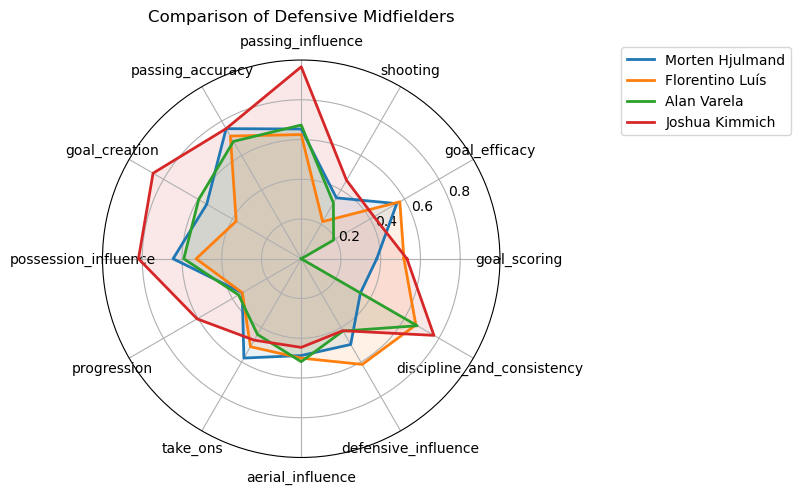

In [19]:
radar_dodecagon(
    players=["Morten Hjulmand", "Florentino Luís", "Alan Varela","Joshua Kimmich"],
    title="Comparison of Defensive Midfielders",
    fill=True
)

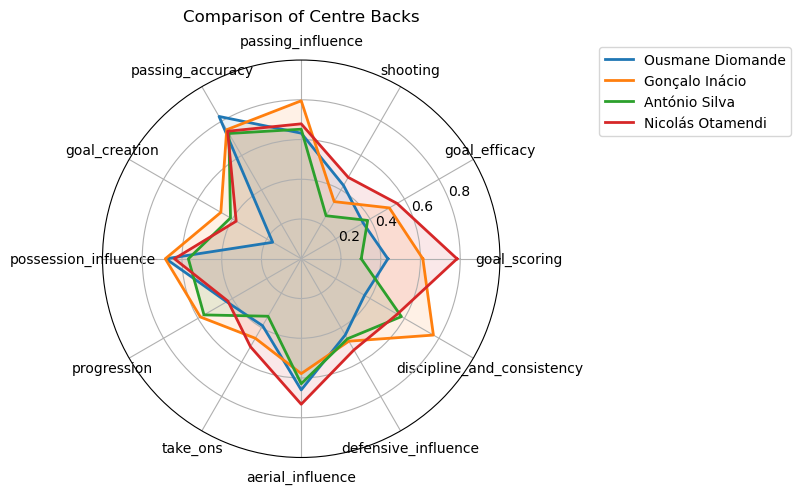

In [20]:
radar_dodecagon(
    players=["Ousmane Diomande", "Gonçalo Inácio", "António Silva", "Nicolás Otamendi"],
    title="Comparison of Centre Backs",
    fill=True
)